In [1]:
import sys
import os
import time
import argparse
import glob
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

current_time_millis = lambda: int(round(time.time() * 1000))

def read_data_with_labels(file, timeVariantColumns, labelColumnNum):
    df = pd.read_csv(file)
    data = df.values.astype('float64')
    tsData = df[timeVariantColumns].values.astype('float64')
    labels = data[:, labelColumnNum].reshape((-1, 1))
    tsDataWithLabels = np.hstack((tsData, labels))
    return tsDataWithLabels, data


def scale(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(data)
    return scaler, scaler.transform(data)


def split_data_set(dataset, split=0.67):
    train_size = int(len(dataset) * split)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test


# input expected to be a 2D array with last column being label
# Returns looked back X (n_samples, n_steps, n_features) and Y (n_samples, 2);
# last column in looked back Y data returned is label
# Only one step ahead prediction setting is expected.

def look_back_and_create_dataset(tsDataWithLabels, look_back=1):
    lookbackTsDataX = []
    lookbackTsDataYAndLabel = []
    for i in range(look_back, len(tsDataWithLabels)):
        a = tsDataWithLabels[i - look_back:i, :-1]
        lookbackTsDataX.append(a)
        lookbackTsDataYAndLabel.append(tsDataWithLabels[i])
    return np.array(lookbackTsDataX), np.array(lookbackTsDataYAndLabel)


def get_train_validation(Xtrain, Ytrain, validation_ratio=0.1):
    validation_size = int(len(Xtrain) * validation_ratio)
    Xtrain, Xvalid = Xtrain[validation_size:], Xtrain[:validation_size]
    Ytrain, Yvalid = Ytrain[validation_size:], Ytrain[:validation_size]
    return Xtrain, Ytrain, Xvalid, Yvalid


def get_deviations(model, X, Y):
    deviations = np.absolute(Y - model.predict(X))
    print("Deviation Min {}, Max {}".format(np.amin(deviations, axis=0), np.amax(deviations, axis=0)))
    return deviations


def get_records_above_deviation_pctile(model, X, Y, pctile=95):
    deviations = get_deviations(model, X, Y)
    pctileDeviationValue = np.percentile(deviations, q=pctile, axis=0)
    print("Deviation {}th pctile {}".format(pctile, pctileDeviationValue))
    labels = (deviations > pctileDeviationValue).astype('int')
    print("Deviation > {}th pctile is_anomaly labels in data {}".format(pctile, np.unique(labels, return_counts=True)))
    return labels

def get_classification_metrics_local(actual, predicted) :
    return confusion_matrix(actual, predicted)

def get_classification_metrics(actual, predicted):
    return get_classification_metrics_local(actual, predicted), precision_score(actual, predicted), \
           recall_score(actual, predicted), f1_score(actual, predicted)
#     return confusion_matrix(actual, predicted), precision_score(actual, predicted), \
#             recall_score(actual, predicted), f1_score(actual, predicted, labels=np.unique(predicted), average='weighted')


# Note here the slight change in how we stack the hidden LSTM layers - special for the last LSTM layer.
def baseline_model(input_shape, learning_rate):
    def build_model(input_shape=input_shape, n_hidden=1, n_units=50, learning_rate=learning_rate):
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=input_shape))
        for layer in range(n_hidden - 1):
            # return sequence = true for all layers except last layer
            model.add(keras.layers.LSTM(n_units, return_sequences=True, activation='relu'))
        model.add(keras.layers.LSTM(n_units, activation='relu'))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(lr=learning_rate)
        model.compile(loss="mse", optimizer=optimizer)
        return model

    return build_model


def plot_actuals_vs_predictions(actual_labels, predictedLabels):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,5))
    plt.subplot(1, 2, 1)
    plt.plot(actual_labels, label='Actual')
    plt.legend(("Actual"), loc=2)

    plt.subplot(1, 2, 2)
    plt.plot(predictedLabels, label='Prediction', color='orange')
    plt.legend("Prediction", loc=2)
    plt.show()



def load_model_for_file(model_persisted_location, benchmark_folder, file_name):
    model_file_extension = '.h5'
    model_file_on_disk = model_persisted_location + os.sep + benchmark_folder \
                         + os.sep + file_name + model_file_extension
    print('Model file will be loaded from ', model_file_on_disk)
    loaded_model = keras.models.load_model(model_file_on_disk)
    return loaded_model


"""
The `perform_training_on_benchmark_directory` is a wrapper fucntion which calls data_read, look_back, split methords  

Description for each parameters

    benchmark_dir             - The full path to a folder where the data resides. This will be the path to a A* Benchmark folders.
    extension_pattern         - File name extension pattern for files of this folder.
    timeVariantColumns        – The time variant column specifies a list of values that changes in time.  In case of Yahoo! It’s the “value” column.
    labelColumnNum            – Specifies the column number which denotes if that record is anomaly or not.  The case of A1Benchmark and A2Benchmark folder the field is marked as “is_anomaly” whereas in case of A3Benchmark and A4Benchmark its “anomaly”
    param_distribs             - Distribution of parameters to search for best model using randomized search.
    files_to_process  - Specifies the number of files that needs to be processed per directory.  
    plot_graph                          – Specifies to plot graph or not for each file.    
    validation_ratio    - What fraction of Xtrain, Ytrain to be used for early stopping validation.
    early_stop_patience - Stop optimizing after how many successive epochs without further loss reduction
    epochs              - Total number of epochs to try and optimize loss.
    batch_size          - Size of batches in each epoch
    n_iter              - number of iterations
    cv                  - cv
    verbosity
    save_model 
"""


# Do it on each benchmark directory files
# def perform_training_on_benchmark_directory(benchmark_dir, extension, timeVariantColumns,
#                                             labelColumnNum, param_distribs, files_to_process='ALL', plot_graph=1,
#                                             validation_ratio=0.1, early_stop_patience=5, epochs=25, batch_size=32,
#                                             n_iter=1, cv=5, verbosity=0, save_model=0, file_name_preferred=None):
def perform_training_on_benchmark_directory(benchmark_dir, extension, timeVariantColumns,
                                            labelColumnNum, files_to_process='ALL', plot_graph=1,
                                            file_name_preferred=None):
    split = 0.8
    look_back = 24
    learning_rate = 0.001
    model_persisted_location = 'models-yahoo-lstm'
    loop_idx = 0;
    files_improved = []
    
    Benchmark_dir = YAHOO_DS + os.path.sep + benchmark_dir + os.path.sep
    benchmark_files = glob.glob(Benchmark_dir + extension, recursive=True)

    if files_to_process == 'ALL':
        num_files_to_process = len(benchmark_files)
    else:
        num_files_to_process = int(files_to_process)

    resultsMap = {}  # results from this folder
    files_to_walk = []
    if file_name_preferred is None:
        files_to_walk = benchmark_files[:num_files_to_process]
    else:
        files_to_walk.append(Benchmark_dir + file_name_preferred)
        num_files_to_process = 1;

    print('Processing {} files in folder {}'.format(num_files_to_process, benchmark_dir))
    # for file_name in benchmark_files[:num_files_to_process]:
    for file_name in files_to_walk:
        loop_idx+= 1
        keras.backend.clear_session()
        print('File Name : ', file_name)

        short_fname = file_name[file_name.rindex(os.sep) + len(os.sep):]
        model = load_model_for_file(model_persisted_location, benchmark_dir, short_fname)
        # read data
        tsDataWithLabels, data = read_data_with_labels(file_name, timeVariantColumns, labelColumnNum)
        print("Shapes: time variant data with labels {}, full data {}".format(tsDataWithLabels.shape, data.shape))

        # scale data
        scaler, tsDataScaled = scale(tsDataWithLabels)

        # Get look back data in the 3D array shape
        lookbackX, lookbackY = look_back_and_create_dataset(tsDataScaled, look_back=look_back)
        print("Look back data shapes: lookbackX {} lookbackY {}".format(lookbackX.shape, lookbackY.shape))

        # actual is_anomaly labels in dataset
        actual_labels = (data[look_back:, labelColumnNum] != 0.0).astype('int')
        
        # get deviations for whole dataset and id records with deviations > pctile threshold and asign an is_anomaly label
        start_millis = current_time_millis()
        
        
        #pctile_start = 99
        pctile_start = 99.9
        pctile = pctile_start 
        pctile_end = 99.99
        idx = 0
        updated = False
        for pctile in np.arange(pctile_start, pctile_end,  0.01):
            predictedLabels = get_records_above_deviation_pctile(model, lookbackX, lookbackY[:, :-1], pctile)
            conf_matrix = get_classification_metrics_local(actual_labels, predictedLabels)
            cur_false_postive = conf_matrix[0][1]
            print("Confusion matrix - Current False postive ",cur_false_postive, ' for percentile ', pctile)
            if cur_false_postive == 0 :
                print('Breaking reties as false postive reached 0')
                break
            if idx == 0 :
                start_false_positive = cur_false_postive
                
            if cur_false_postive < start_false_positive  and not updated:
                files_improved.append(file_name)
                updated = True
            
            idx+= 1
        end_millis = current_time_millis()

        print("Actual is_anomaly labels in data", np.unique(actual_labels, return_counts=True))
        
        # Compare calculated labels and actual labels to find confusion matrix, precision, recall, and F1
        conf_matrix, prec, recall, f1 = get_classification_metrics(actual_labels, predictedLabels)
        print("Confusion matrix \n{0}\nprecision {1:.5f}, recall {2:.5f}, f1 {3:.5f}".format(conf_matrix, prec, recall,
                                                                                             f1))
        print("Time to predict and get records above deviation : {} ms".format(end_millis - start_millis))

        if len(np.unique(actual_labels)) == 1 and  np.unique(actual_labels)[0] == 0 :
            print ('File ', file_name,  ' contains ONLY non anomalous values – ignoring addition to the map')
        else :
            resultsMap[file_name] = {'predict_time': (end_millis - start_millis),
                                 'precision': prec, 'recall': recall, 'f1': f1, 'confusion_matrix': conf_matrix}

        if plot_graph == 1:
            plot_actuals_vs_predictions(actual_labels, predictedLabels )
            
    return resultsMap, files_improved


def print_summary_for_benchmark_folder(resultsMap, benchmark_folder):
    precisions = []
    recalls = []
    f1s = []
    times = []
    for v in resultsMap.values():
        precisions.append(v['precision'])
        recalls.append(v['recall'])
        f1s.append(v['f1'])
        #times.append(v['traintime'])
    avg_prec = np.average(np.array(precisions))
    avg_recall = np.average(np.array(recalls))
    avg_f1 = np.average(np.array(f1s))
    
    min_prec = min(np.array(precisions))
    min_recall = min(np.array(recalls))
    min_f1 = min(np.array(f1s))
    
    max_prec = max(np.array(precisions))
    max_recall = max(np.array(recalls))
    max_f1 = max(np.array(f1s))
    
    print(benchmark_folder)   
    print("     Avg precision {0:.5f} recall {1:.5f} f1 {2:.5f} ".format(avg_prec, avg_recall, avg_f1))
    print("     Min precision {0:.5f} recall {1:.5f} f1 {2:.5f} ".format(min_prec, min_recall, min_f1))
    print("     Max precision {0:.5f} recall {1:.5f} f1 {2:.5f} ".format(max_prec, max_recall, max_f1))
    
    plt.figure(figsize=(40,10))
    plt.plot(precisions, label ='Precisions')
    plt.plot(recalls, label ='Recall')
    plt.plot(f1s, label ='F1s')
    plt.legend(("Precisions", 'Recall', "F1"), loc=3)
    plt.show()
    

Processing 67 files in folder A1Benchmark
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_1.csv.h5
Shapes: time variant data with labels (1420, 2), full data (1420, 3)
Look back data shapes: lookbackX (1396, 24, 1) lookbackY (1396, 2)
Deviation Min [1.70660949e-05], Max [0.89037086]
Deviation 99.9th pctile [0.45637285]
Deviation > 99.9th pctile is_anomaly labels in data (array([0, 1]), array([1394,    2]))
Confusion matrix - Current False postive  0  for percentile  99.9
Breaking reties as false postive reached 0
Actual is_anomaly labels in data (array([0, 1]), array([1394,    2]))
Confusion matrix 
[[1394    0]
 [   0    2]]
precision 1.00000, recall 1.00000, f1 1.00000
Time to predict and get records above deviation : 4279 ms
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_10.csv


/root/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [3.23486595e-05], Max [0.75653738]
Deviation 99.9th pctile [0.53073676]
Deviation > 99.9th pctile is_anomaly labels in data (array([0, 1]), array([1435,    2]))
Confusion matrix - Current False postive  0  for percentile  99.9
Breaking reties as false postive reached 0
Actual is_anomaly labels in data (array([0, 1]), array([1432,    5]))
Confusion matrix 
[[1432    0]
 [   3    2]]
precision 1.00000, recall 0.40000, f1 0.57143
Time to predict and get records above deviation : 1596 ms
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_37.csv.h5
Shapes: time variant data with labels (1434, 2), full data (1434, 3)
Look back data shapes: lookbackX (1410, 24, 1) lookbackY (1410, 2)
Deviation Min [0.00014812]

/root/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shapes: time variant data with labels (1439, 2), full data (1439, 3)
Look back data shapes: lookbackX (1415, 24, 1) lookbackY (1415, 2)
Deviation Min [2.17839575e-05], Max [0.7199837]
Deviation 99.9th pctile [0.52571756]
Deviation > 99.9th pctile is_anomaly labels in data (array([0, 1]), array([1413,    2]))
Confusion matrix - Current False postive  0  for percentile  99.9
Breaking reties as false postive reached 0
Actual is_anomaly labels in data (array([0, 1]), array([1407,    8]))
Confusion matrix 
[[1407    0]
 [   6    2]]
precision 1.00000, recall 0.25000, f1 0.40000
Time to predict and get records above deviation : 3377 ms
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_60.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_60.csv.h5
Shapes: time variant data with labels (1461, 2), full data (1461, 3)
Look back data shapes: lookbackX (1437, 24, 1) lookbackY (1437, 2)
Deviation Min [2.47492424e-

/root/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shapes: time variant data with labels (1424, 2), full data (1424, 3)
Look back data shapes: lookbackX (1400, 24, 1) lookbackY (1400, 2)
Deviation Min [1.83927937e-05], Max [0.7962832]
Deviation 99.9th pctile [0.54391276]
Deviation > 99.9th pctile is_anomaly labels in data (array([0, 1]), array([1398,    2]))
Confusion matrix - Current False postive  0  for percentile  99.9
Breaking reties as false postive reached 0
Actual is_anomaly labels in data (array([0, 1]), array([1383,   17]))
Confusion matrix 
[[1383    0]
 [  15    2]]
precision 1.00000, recall 0.11765, f1 0.21053
Time to predict and get records above deviation : 1168 ms
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_66.csv
Model file will be loaded from  models-yahoo-lstm/A1Benchmark/real_66.csv.h5
Shapes: time variant data with labels (1424, 2), full data (1424, 3)
Look back data shapes: lookbackX (1400, 24, 1) lookbackY (1400, 2)
Deviation Min [3.85612941e-

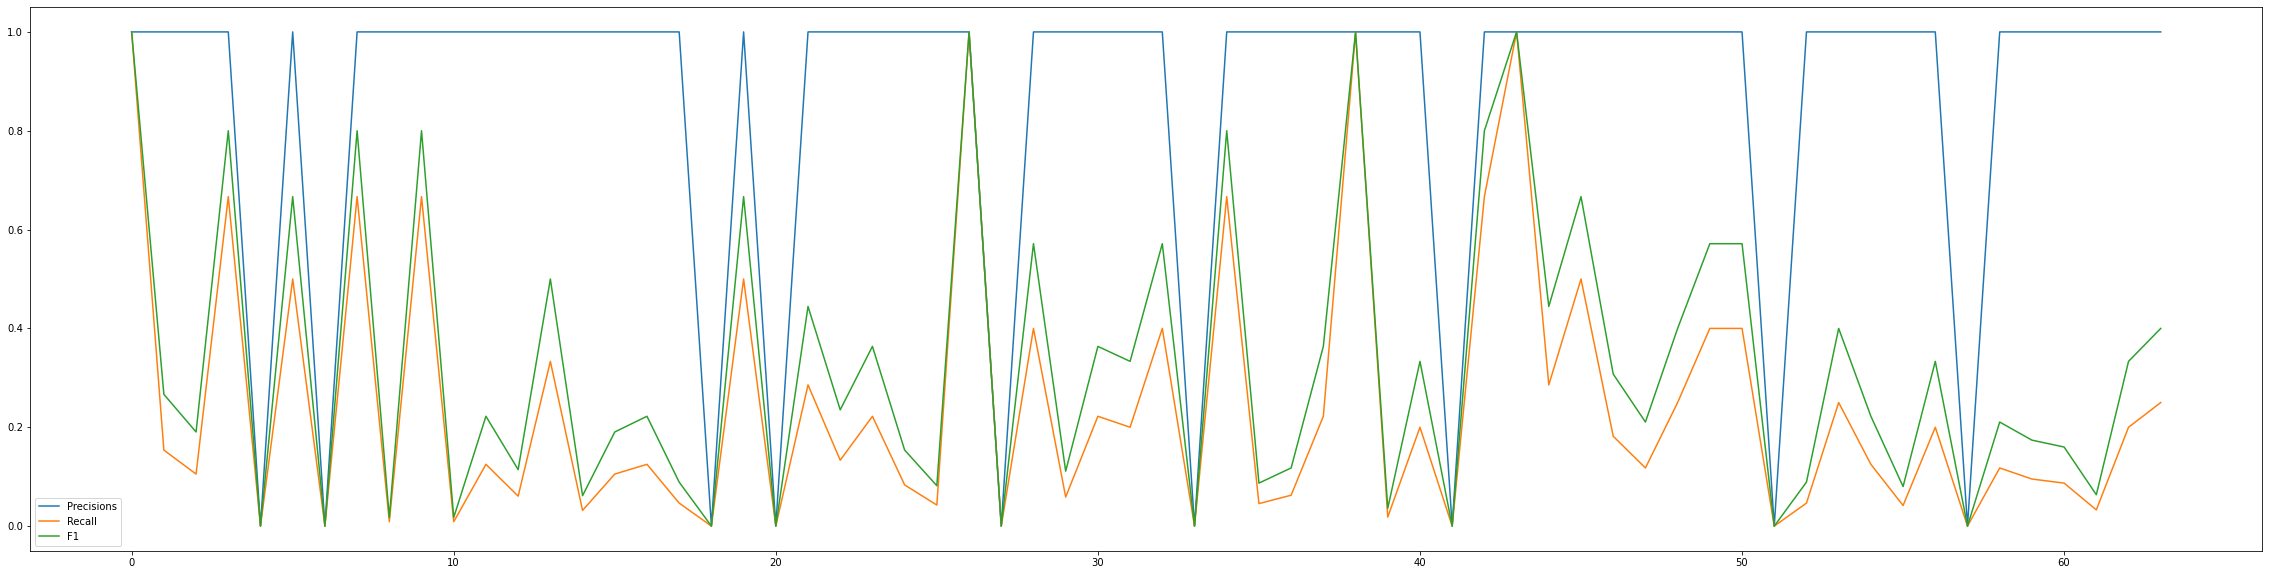

A2Benchmark
     Avg precision 0.98000 recall 0.55333 f1 0.65667 
     Min precision 0.00000 recall 0.00000 f1 0.00000 
     Max precision 1.00000 recall 1.00000 f1 1.00000 


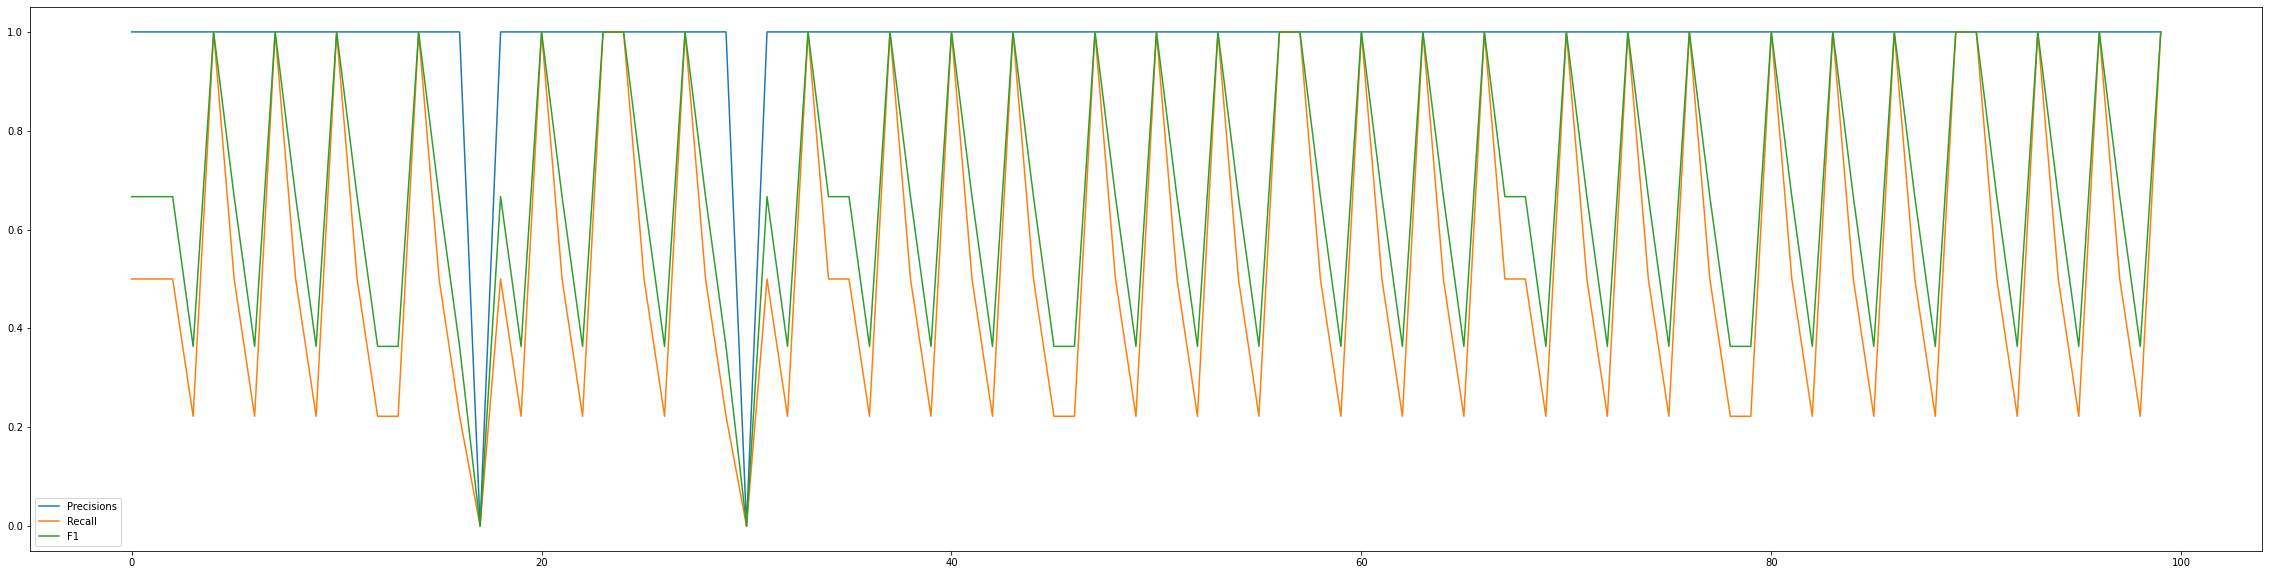

A3Benchmark
     Avg precision 0.88000 recall 0.26658 f1 0.37467 
     Min precision 0.00000 recall 0.00000 f1 0.00000 
     Max precision 1.00000 recall 1.00000 f1 1.00000 


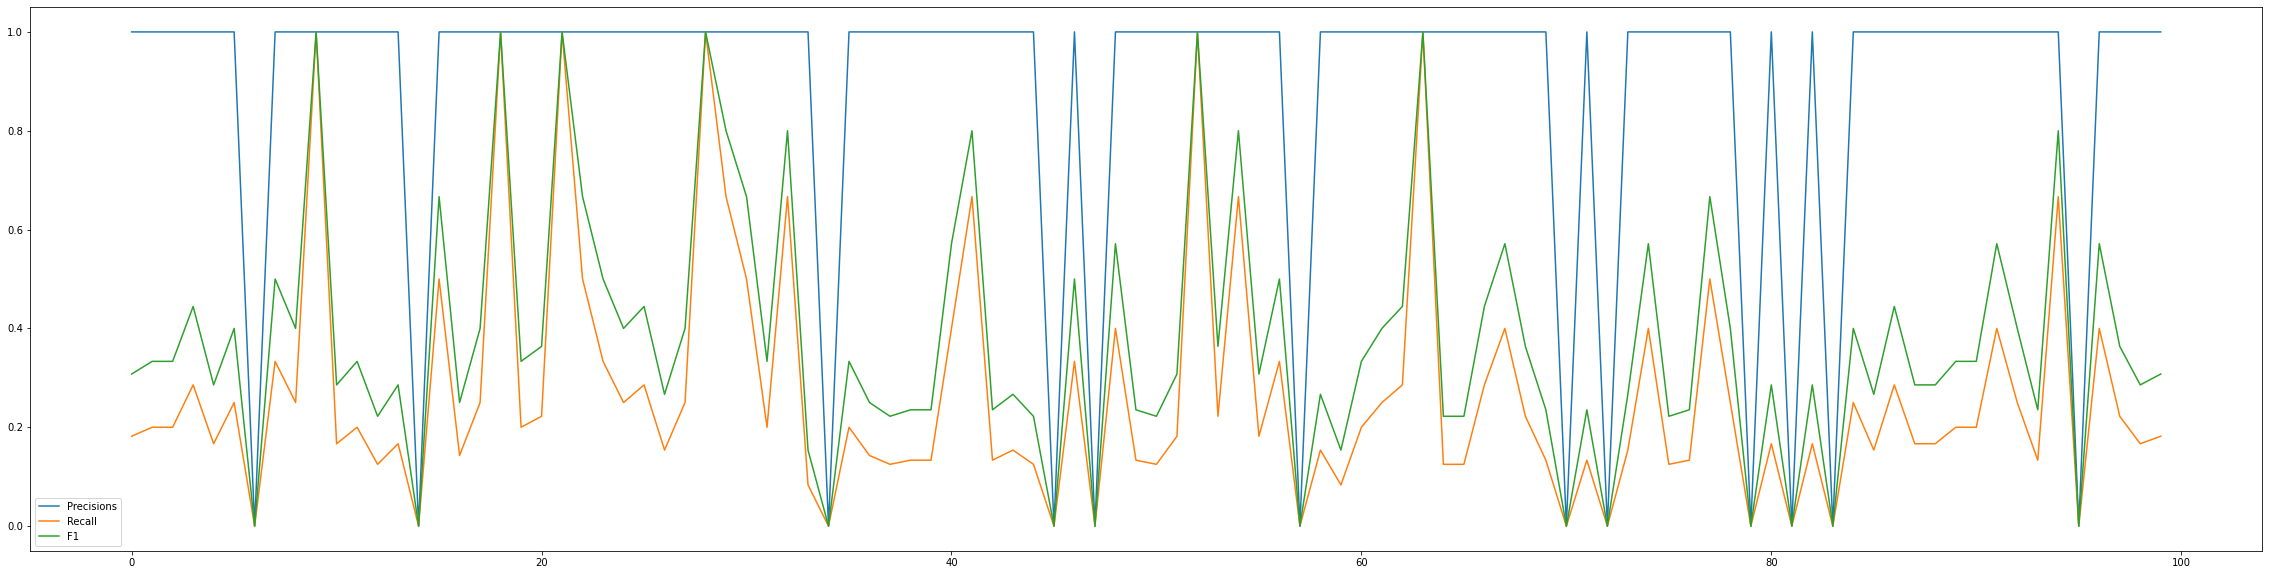

A4Benchmark
     Avg precision 0.84000 recall 0.27258 f1 0.37247 
     Min precision 0.00000 recall 0.00000 f1 0.00000 
     Max precision 1.00000 recall 1.00000 f1 1.00000 


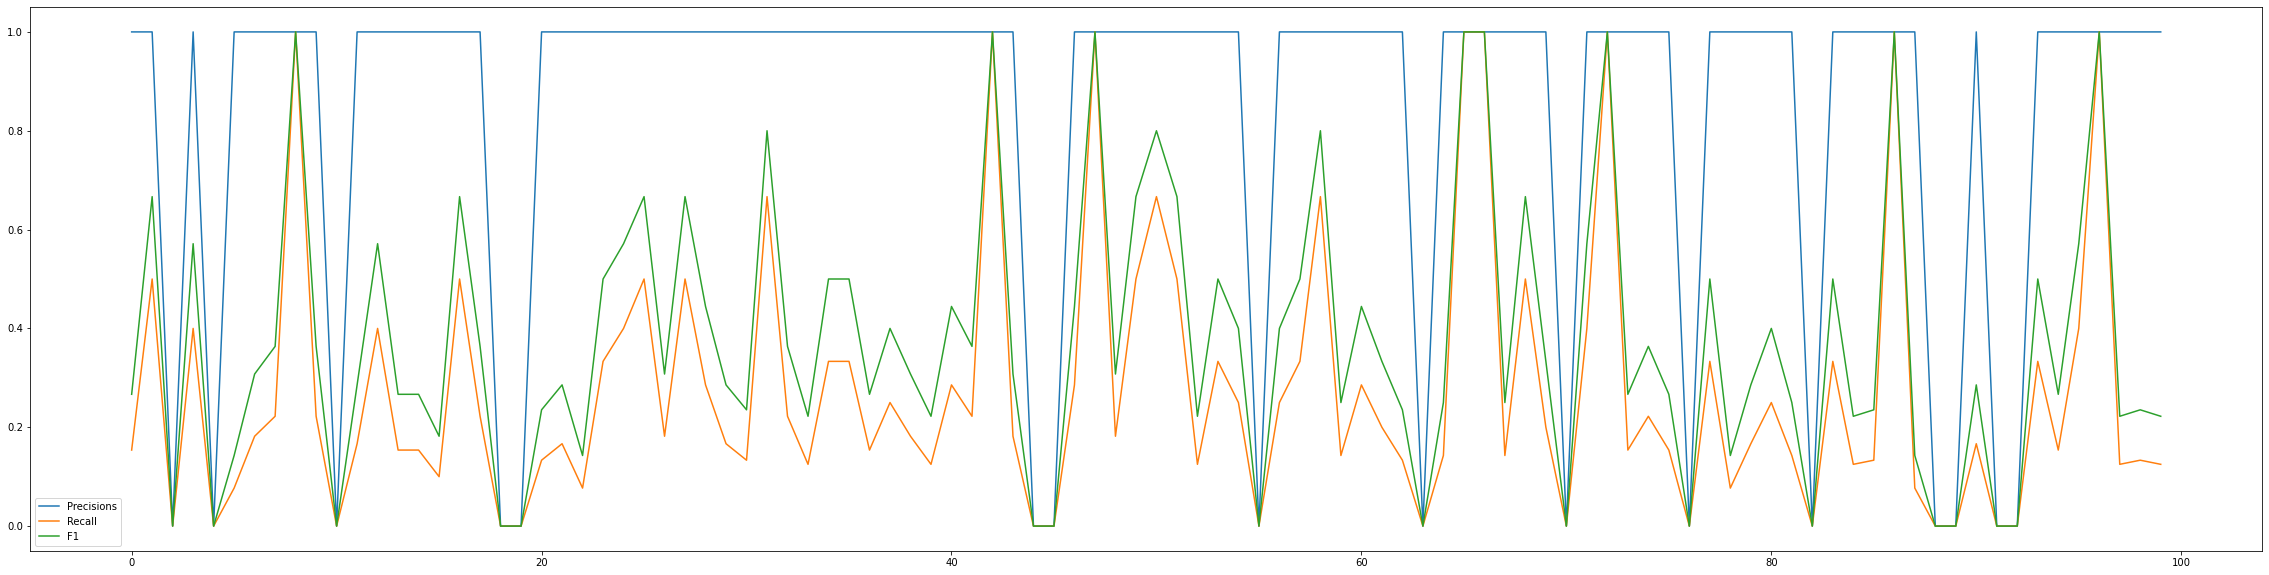

Files with Scores improved due to dynamic thresholding
A1Benchmark
------------------
           .
           .
           /
           .
           .
           /
           S
           t
           o
           c
           h
           a
           s
           t
           i
           c
           -
           M
           e
           t
           h
           o
           d
           s
           /
           d
           a
           t
           a
           /
           y
           a
           h
           o
           o
           /
           d
           a
           t
           a
           s
           e
           t
           /
           y
           d
           a
           t
           a
           -
           l
           a
           b
           e
           l
           e
           d
           -
           t
           i
           m
           e
           -
           s
           e
           r
           i
           e
           s
           -
    

In [2]:
YAHOO_DS = "../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0"

DIRS_FILE_EXTENSIONS = {'A1Benchmark': "*.csv", \
                            'A2Benchmark': "*.csv", \
                            'A3Benchmark': "*TS*.csv", \
                            'A4Benchmark': "*TS*.csv"}

# DIRS_FILE_EXTENSIONS = {'A1Benchmark': "*.csv"}

directoryResultsMap = {}
directoryResultsMapFilesImproved = {}
start_millis = current_time_millis()
for folder in DIRS_FILE_EXTENSIONS:
    extension = DIRS_FILE_EXTENSIONS[folder]
    timeVariantColumns = ['value']
    labelColumnNum = 2
    resultsMap, files_improved = perform_training_on_benchmark_directory(folder, extension, timeVariantColumns, labelColumnNum,
                                                             files_to_process='ALL', plot_graph=0, file_name_preferred=None)
#     resultsMap = perform_training_on_benchmark_directory(folder, extension, timeVariantColumns, labelColumnNum,
#                                                              files_to_process='ALL', plot_graph=1, file_name_preferred='real_1.csv')
    directoryResultsMap[folder] = resultsMap
    directoryResultsMapFilesImproved[folder] = files_improved

end_millis = current_time_millis()
print("Total Time to process all the selected files : {} ms".format(end_millis - start_millis))

# finally Print summary for each directory
for directory in directoryResultsMap.keys():
    print_summary_for_benchmark_folder(directoryResultsMap[directory], directory)
    

print ('Files with Scores improved due to dynamic thresholding')
for directory in directoryResultsMap.keys():
    print(directory)
    print('------------------')
    for filesList in directoryResultsMapFilesImproved[directory] :
        print (filesList )

In [3]:
print ('Files with Scores improved due to dynamic thresholding')
for directory in directoryResultsMap.keys():
    print(directory)
    print('------------------')
    for filesList in directoryResultsMapFilesImproved[directory] :
        print (filesList )
            

Files with Scores improved due to dynamic thresholding
A1Benchmark
------------------
../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_26.csv
../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_28.csv
../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_34.csv
../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_35.csv
../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_40.csv
../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_48.csv
../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_59.csv
../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_64.csv
A2Benchmark
------------------
A3Benchmark